In [ ]:
# !pip install hazm

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [ ]:
from hazm import Normalizer, word_tokenize, stopwords_list

data = pd.read_csv('/content/csv (1).csv')

normalizer = Normalizer()


def clean_text_farsi(text):

    text = normalizer.normalize(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords_list())
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

data['question_clean'] = data['question'].apply(clean_text_farsi)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(data['button'])


X_train_text, X_test_text, y_train, y_test = train_test_split(
    data['question_clean'], y, test_size=0.2, random_state=42
)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams vs. Unigrams + Bigrams
    'clf__C': [0.01, 0.1, 1, 10, 100]
}

# Run grid search with 5-fold cross-validation
grid_search_pipe = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search_pipe.fit(X_train_text, y_train)

print("Best parameters:", grid_search_pipe.best_params_)
print("Best cross-validation accuracy:", grid_search_pipe.best_score_)



Best parameters: {'clf__C': 10, 'tfidf__ngram_range': (1, 1)}
Best cross-validation accuracy: 0.9298870056497174



Test set accuracy: 0.8933333333333333
Classification Report on Test Set:
                 precision    recall  f1-score   support

         ابطال       0.92      1.00      0.96        22
 ثبت نام حقیقی       0.88      0.70      0.78        10
        دارایی       0.00      0.00      0.00         1
           سود       0.92      0.92      0.92        12
          صدور       0.90      0.90      0.90        21
پروفایل کاربری       0.67      1.00      0.80         2
     گردش حساب       0.86      0.86      0.86         7

      accuracy                           0.89        75
     macro avg       0.73      0.77      0.74        75
  weighted avg       0.88      0.89      0.89        75



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


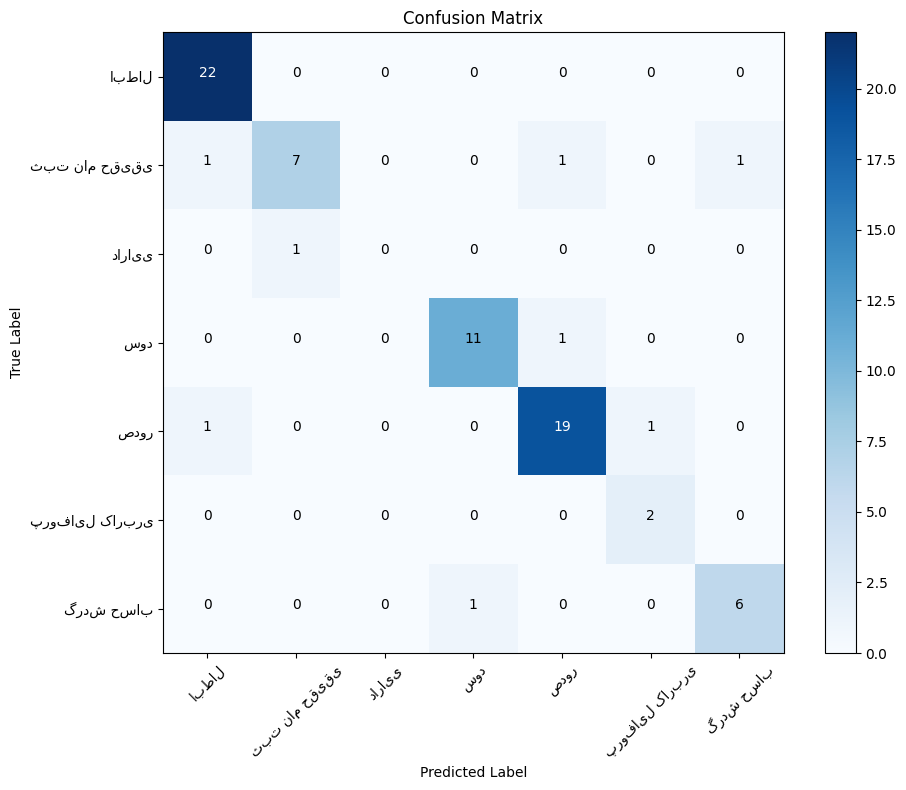

In [ ]:
y_pred_pipe = grid_search_pipe.predict(X_test_text)

print("\nTest set accuracy:", accuracy_score(y_test, y_pred_pipe))
print("Classification Report on Test Set:\n",
      classification_report(y_test, y_pred_pipe, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_pipe)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

# Annotate each cell with the count
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
best_vectorizer = grid_search_pipe.best_estimator_.named_steps['tfidf']
best_clf = grid_search_pipe.best_estimator_.named_steps['clf']

feature_names = best_vectorizer.get_feature_names_out()
coef = best_clf.coef_

for i, class_label in enumerate(le.classes_):
    if i < coef.shape[0]:  # Check if i is within bounds of coef
        top_n = 5
        top_feature_indices = np.argsort(coef[i])[-top_n:][::-1]
        top_features = feature_names[top_feature_indices]
        print(f"Top features for class '{class_label}': {top_features}")

Top features for class 'ابطال': ['ابطال' 'فروش' 'کار' 'پول' 'واحد']
Top features for class 'ثبت نام حقیقی': ['نام' 'سرمایه' 'ثبت' 'مشترک' 'حساب']
Top features for class 'دارایی': ['سود' 'محاسبه' 'ماه' 'سودم' 'میشه']
Top features for class 'سود': ['صدور' 'افزایش' 'مبلغ' 'لوتوس' 'دارایی']
Top features for class 'صدور': ['شماره' 'تلفن' 'انتخاب' 'روشی' 'شرکت']
Top features for class 'پروفایل کاربری': ['گردش' 'دریافت' 'تمکن' 'ارائه' 'حساب']


In [ ]:
import joblib

label_mapping = dict(enumerate(le.classes_))

# Save both the trained pipeline and label mapping together
model_data = {
    'model': grid_search_pipe,
    'label_mapping': label_mapping
}
joblib.dump(model_data, 'model_with_labels.pkl')

['model_with_labels.pkl']

In [ ]:
new_texts = [
    "نحوه محاسبه سود صندوق را اعلام کنید ؟",
    "کی سود نیکوکاری رویان را میریزید ؟",
    "چه روزی برای ابطال در صندوق نیکوکاری رویان شامل سود کامل می شود ؟",
    "سلام وقتتون بخیر شهیدی هستم بفرمایین سلام خانم خسته نباشین عذرخواهی میکنم من یه پنج دقیقه پیش با دوتا هم کار از اون صحبت کردم ولی یه چندی توضیح نشده هم میشه مزاحمتون شدم بله بفرمایین اره خانم نرخی صدور ابطاله دون شما چی میاد رو سیستم نرخ صدور ابطال بله عذرخواهی میکنم بذار من توضیح بدم منظرات رو خانم من بیست تومن هشتاد و هشت میلیون",
    "سلام وقتتون بخیر غیبی هستم. الو سلام خسته نباشید. سلامت باشین بفرمایید. عذرخواهی می‌کنم من یه حساب باز کرده بودم بعد الان رمز چیزمو رمز عبورم یادم رفته. سرکار خانم اگه شما رمزتون رو فراموش کردید شما فقط رمز عبور رو می‌زنید یه کد بازیابی به شماره موبایلتون ۰۹۰۵ سه رقم آخر ۹۳۲ ارسال میشه کد بازیابی که براتون ارسال شد شما کد بازیابی رو وارد می‌کنید پایینش زده رمز عبور جدید تکرار رمز عبور یه رمز عبور جدید هشت رقمی برای خودتون می‌سازید که سعی کنید از هشت تا عدد استفاده کنید از حروف استفاده نکنید رمز عبور جدیدتون رو که ساختید مجدداً برمی‌گردیم به صفحه قبلی‌تون کد کاربریتون که همیشه کد ملیتونه رمز عبور هم میشه رمزی که برای خودتون جدید ساختید و با اون وارد پنل کاربری لوتوستون میشید. آها بعد اینکه من سیمکارتی که این پور‌تالم روش باز اون حسابم روش بوده الان خاموشه امکانش هست که کلا بخاطر اینکه سیمکارتم خاموشه بالا نمیاد چون رمزی که من می‌زنم حالت چشمی اگه می‌دونین دیگه من زدم رمزم بالا اومد ولی خب شک دارم اینه اونه چون هر سرکار خانم اگه این شماره موبایلتون در دسترس نیست خب میتونین اول وارد سامانه سجام بشید شماره موبایل جدیدتون رو سامانه سجام ثبت بکنید شماره موبایل جدیدی تون رو که سامانه سجام ثبت کردید بعد از گذشت ۲۴ ساعت وارد لوتوس بشید گزینه ورود به سامانه رو که بزنید پایین صفحه زده به روز رسانی اطلاعات از طریق سجام اونو که بزنید یه کد برای شماره موبایل جدیدتون به سامانه سجام ارسال میشه اون کد رو که وارد کردید شماره موبایلتون تو لوتوس تغییر پیدا می‌کنه و بعد از اینکه شماره موبایلتون تو لوتوس تغییر پیدا کرد شما فراموشی رمز عبور رو میزنید و تمام مراحلی که عرض کردم خدمتتون رو انجام میدین رمز عبور جدید جدیدتون رو می‌سازید و وارد پنل کاربریتون میشید. نه مشکل نداره حالا سیمکارتمو دارم فوقش روشن می‌کنم چون می‌خوام یه مقدار پول بخوابونم به حساب به خاطر همین البته اگه می‌خواین صدور انجام بدید سرکار خانم برای صندوق لوتوس شما شنبه ۲۷م صدور انجام بدید. آها که بخاطر سود الان چند درصد شده؟ سود صندوق لوتوس برای یک دوره کامل سرکار خانم ۲۳ درصد سالانه است که ماهانه پرداخت میشه. درسته آره داشتم. ۲۱م تا ۲۴م کلا روز مناسب برای سرمایه گذاری نیست چون هم نرخ صدور بالاتره و هم اینکه چهار روز ماندگاری تا پایان دوره حفظ نمیشه که باید بهتون سود تعلق بگیره. آها پس همون ۲۷م اینا خیلی بهتره. انجام بدین بله. درسته. خیلی ممنون آقا لطف کردین. پس من نیازی نیست دیگه تا بانک بیام یا اقدام کنم برای چیزی دیگه همین خودم می‌تونم مشکلمو حل کنم. خیلی ممنون لطف کردید آقا. خواهش می‌کنم خدانگهدار. سلامت باشید خداحافظ.",
    """سلام وقت بخیر. بفرمایید.
سلام. وقت شما هم بخیر باشه. مرسی.
ببخشید من امروز یه دونه سهم یه دونه چون میخواستم رند بشه سهمم ۱۱۰ تومنی خریدم ولی تو حسابم ننشسته. یعنی داخل چیز مشاهده‌ش نمی‌کنم. چرا؟
به نام آقای امیر منوچهری؟
بله بله.
کی صدور انجام دادید؟
فکر می‌کنم صبح بود انجام دادم.
منم اینجا صدور براتون اینجا مشاهده نمیکنم. تو قسمت درخواستاتون صدورتون رو مشاهده کردید؟
من نه. ندیدمش.
مبلغ از حسابتون کسر شد؟
بله.
اجازه بدید انتقال‌تون میدم بخش صدور صندوق اونجا از همکارا سوالتون رو بکنید. چون من اینجا دارم نگاه میکنم صدوری برای شما نمی‌بینم جناب. یه لحظه اجازه بدید.
بله بفرمایید.
سلام. خسته نباشید.
سلامت باشید. ممنون متشکر.
ببخشید من یه صدور زدم صبح ساعت ۹ و ۱۰ دقیقه از حسابم کسر شده ولی تو داشبورد نمی‌بینمش. با همکار صحبت کردم.
تو داشبورد که نمایش نمی‌ده. تو داشبورد روز کاری بعد به دارایی‌تون اضافه میشه. الان تو قسمت صدور.
خب می‌دونم ولی مثلا می‌نویسه که مثلا من یه صدور داشتم. درسته؟
در جریان صدور می‌زنه ولی بعضی وقتا اون در جریان صدور طول می‌کشه. آقای امیر منوچهری یه صدور داشتن ساعت ۹:۲۵ دقیقه به مبلغ ۱۱۰ هزار تومن براشون ثبت شد.
بله بله.
بله.
آها پس مشکلی نداره درسته؟
نه مشکلی نداره فردا به دارایی‌تون اضافه میشه.
ممنونم. زنده باشید.
خواهش میکنم. قربان شما. خدانگهدار.
خداحافظ.
""",
"""سلام وقت بخیر آقای غریبی هستم بفرمایید. سلام، وقت شما هم بخیر. می بخشید یه سوالی داشتم. می خواستم ببینم یک میلیارد ماهانه چند سودشه؟
 برای شش ماهه دوم سال که دوره ۳۰ روزه، آره. که ۱۹ میلیون تومن،
 بابت شش ماهه اول سال که دوره ۳۱ روزه، ۱۹ میلیون و ۵۰۰ هزار تومن. ۵۰۰ تومن فرق می کنه. بله، بله.
 تشکر می کنم. لطف کردید. خواهش می کنم. خدانگهدار.
 خدانگهدار.
"""
]

model_data = joblib.load('model_with_labels.pkl')
loaded_model = model_data['model']
label_mapping = model_data['label_mapping']

predictions = loaded_model.predict(new_texts)
predicted_labels = [label_mapping[pred] for pred in predictions]
print(predicted_labels)


['سود', 'سود', 'ابطال', 'ابطال', 'پروفایل کاربری', 'صدور', 'سود']


# NNs

In [ ]:
# If you're running locally or in Colab and need these:
# !pip install hazm tensorflow scikit-learn matplotlib joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from hazm import Normalizer, word_tokenize, stopwords_list

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import joblib


In [ ]:
# Load your CSV data
data = pd.read_csv('/content/csv (1).csv')  # Adjust the path if needed

normalizer = Normalizer()

def clean_text_farsi(text):
    text = normalizer.normalize(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords_list())
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['question_clean'] = data['question'].apply(clean_text_farsi)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(data['button'])


In [ ]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    data['question_clean'],
    y,
    test_size=0.2,
    random_state=42
)

# Initialize and fit TF-IDF on the training set
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print("TF-IDF training data shape:", X_train_tfidf.shape)
print("TF-IDF test data shape:", X_test_tfidf.shape)


TF-IDF training data shape: (299, 1173)
TF-IDF test data shape: (75, 1173)


In [ ]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_tfidf.toarray(),
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1360 - loss: 1.9464 - val_accuracy: 0.4667 - val_loss: 1.9016
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3872 - loss: 1.8917 - val_accuracy: 0.4333 - val_loss: 1.8431
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4661 - loss: 1.8198 - val_accuracy: 0.4333 - val_loss: 1.7623
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4360 - loss: 1.7347 - val_accuracy: 0.4333 - val_loss: 1.6549
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5409 - loss: 1.5849 - val_accuracy: 0.5000 - val_loss: 1.5045
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5927 - loss: 1.4172 - val_accuracy: 0.6000 - val_loss: 1.3197
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6440 - loss: 1.2380 - val_accuracy: 0.6333 - val_loss: 1.1200
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7261 - loss: 1.0168 - val_accuracy: 0.7667 - val_loss: 0.9283


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8051 - loss: 0.7280
Test accuracy: 0.8133333325386047
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Classification Report on Test Set:
                 precision    recall  f1-score   support

         ابطال       0.95      0.95      0.95        22
 ثبت نام حقیقی       0.80      0.40      0.53        10
        دارایی       0.00      0.00      0.00         1
           سود       0.83      0.83      0.83        12
          صدور       0.71      0.95      0.82        21
پروفایل کاربری       0.00      0.00      0.00         2
     گردش حساب       0.75      0.86      0.80         7

      accuracy                           0.81        75
     macro avg       0.58      0.57      0.56        75
  weighted avg       0.79      0.81      0.79        75

Accuracy Score: 0.8133333333333334


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


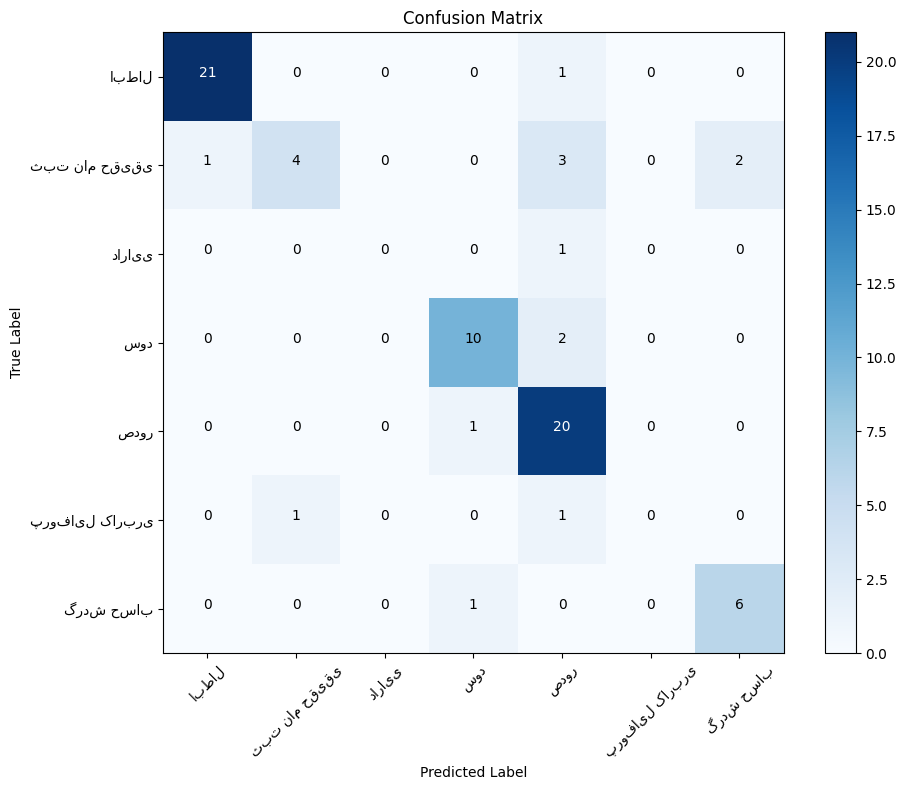

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_tfidf.toarray(), y_test)
print("Test accuracy:", test_accuracy)

# Generate predictions
y_pred = model.predict(X_test_tfidf.toarray())
y_pred_class = np.argmax(y_pred, axis=1)

print("\nClassification Report on Test Set:\n",
      classification_report(y_test, y_pred_class, target_names=le.classes_))
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
# Save the Keras model
model.save('farsi_classification_model.h5')

# Save TF-IDF and LabelEncoder with joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('farsi_classification_model.h5')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')
loaded_le = joblib.load('label_encoder.pkl')


In [ ]:
new_texts = [
    "نحوه محاسبه سود صندوق را اعلام کنید؟",
    "کی سود نیکوکاری رویان را میریزید؟",
    "امروز هم ابطال بزنم سود رو می‌گیرم؟"
]

# 1) Clean the new texts
new_texts_cleaned = [clean_text_farsi(txt) for txt in new_texts]

# 2) Convert them to TF-IDF vectors
new_texts_tfidf = loaded_tfidf.transform(new_texts_cleaned).toarray()

# 3) Predict with the loaded model
predictions = loaded_model.predict(new_texts_tfidf)
predicted_classes = np.argmax(predictions, axis=1)

# 4) Decode label indices back to original label strings
predicted_labels = [loaded_le.inverse_transform([cls])[0] for cls in predicted_classes]

print("Predicted labels:", predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted labels: ['سود', 'سود', 'سود']


In [ ]:
# Load model and associated objects
loaded_model = load_model('farsi_classification_model.h5')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')
loaded_le = joblib.load('label_encoder.pkl')

def predict_with_threshold(texts, threshold=0.7):
    """
    Predict multiple possible classes if probabilities exceed 'threshold'.
    Otherwise, fallback to the single highest-probability class.
    """

    # Clean texts
    cleaned = [clean_text_farsi(t) for t in texts]

    # TF-IDF transform
    X_tfidf = loaded_tfidf.transform(cleaned).toarray()

    # Predict probabilities
    probs = loaded_model.predict(X_tfidf)  # shape: (num_texts, num_classes)

    all_predicted_labels = []
    for row in probs:
        # Indices of classes whose prob > threshold
        high_conf_indices = np.where(row > threshold)[0]

        if len(high_conf_indices) == 0:
            # No class passes threshold => pick top-1
            top1_idx = np.argmax(row)
            all_predicted_labels.append([loaded_le.inverse_transform([top1_idx])[0]])
        else:
            # Return all classes passing threshold
            predicted_label_names = loaded_le.inverse_transform(high_conf_indices)
            all_predicted_labels.append(list(predicted_label_names))

    return all_predicted_labels

# Example usage:
new_texts = [
    "نحوه محاسبه سود صندوق را اعلام کنید؟",
    "کی سود نیکوکاری رویان را میریزید؟",
    "امروز هم ابطال بزنم سود رو می‌گیرم؟"
]

predictions_thresholded = predict_with_threshold(new_texts, threshold=0.3)
for text, preds in zip(new_texts, predictions_thresholded):
    print("Text:", text)
    print("Predicted label(s):", preds)
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Text: نحوه محاسبه سود صندوق را اعلام کنید؟
Predicted label(s): ['سود']
--------------------------------------------------
Text: کی سود نیکوکاری رویان را میریزید؟
Predicted label(s): ['سود']
--------------------------------------------------
Text: امروز هم ابطال بزنم سود رو می‌گیرم؟
Predicted label(s): ['سود']
--------------------------------------------------
